In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Union, Optional
import json
import re

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class DataAnalyzer:
    """
    Generic data analyzer for runtime metrics and other performance data.
    Easily extensible for different metrics and file formats.
    """
    
    def __init__(self):
        self.data = {}
        self.metadata = {}
    
    def load_files(self, 
                   file_paths: Union[str, List[str]], 
                   metric_name: str = "value",
                   label_extractor: Optional[callable] = None) -> None:
        """
        Load data from one or more files.
        
        Args:
            file_paths: Single file path or list of file paths
            metric_name: Name of the metric (e.g., 'latency', 'throughput')
            label_extractor: Optional function to extract label from Path object
        """
        if isinstance(file_paths, str):
            file_paths = [file_paths]
        
        for file_path in file_paths:
            path = Path(file_path)
            
            if not path.exists():
                print(f"Warning: {file_path} not found, skipping...")
                continue
            
            # Extract label from path
            if label_extractor:
                label = label_extractor(path)
            else:
                label = path.stem
            
            # Load data based on file extension
            if path.suffix == '.csv':
                df = pd.read_csv(file_path, header=None, names=[metric_name])
            elif path.suffix == '.json':
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                df = pd.DataFrame(json_data)
            elif path.suffix == '.jsonl':
                # Read JSONL (one JSON object per line)
                df = pd.read_json(file_path, lines=True)
            else:
                print(f"Warning: Unsupported file type {path.suffix}")
                continue
            
            self.data[label] = df
            self.metadata[label] = {
                'file_path': str(file_path),
                'metric_name': metric_name,
                'num_samples': len(df)
            }
            
            print(f"Loaded {len(df)} samples from {path.name} -> '{label}'")
    
    def load_pattern(self, 
                     pattern: str, 
                     metric_name: str = "value",
                     label_extractor: Optional[callable] = None) -> None:
        """
        Load all files matching a glob pattern.
        
        Args:
            pattern: Glob pattern (e.g., 'experiments/logs/*.csv')
            metric_name: Name of the metric
            label_extractor: Optional function to extract label from Path object
        """
        files = list(Path('.').glob(pattern))
        if not files:
            print(f"No files found matching pattern: {pattern}")
            return
        
        file_paths = [str(f) for f in files]
        self.load_files(file_paths, metric_name, label_extractor)
    
    def compute_statistics(self, percentiles: List[float] = [50, 90, 95, 99]) -> pd.DataFrame:
        """
        Compute comprehensive statistics for all loaded datasets.
        
        Args:
            percentiles: List of percentiles to compute
            
        Returns:
            DataFrame with statistics for each dataset
        """
        stats_list = []
        
        for label, df in self.data.items():
            metric_name = self.metadata[label]['metric_name']
            values = df[metric_name]
            
            stats = {
                'dataset': label,
                'metric': metric_name,
                'count': len(values),
                'mean': values.mean(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
            }
            
            # Add percentiles
            for p in percentiles:
                stats[f'p{p}'] = values.quantile(p/100)
            
            stats_list.append(stats)
        
        return pd.DataFrame(stats_list)
    
    def plot_distributions(self, 
                          datasets: Optional[List[str]] = None,
                          plot_type: str = 'hist',
                          bins: int = 50,
                          figsize: tuple = (14, 6)) -> None:
        """
        Plot distributions of metrics.
        
        Args:
            datasets: List of dataset labels to plot (None = all)
            plot_type: 'hist', 'kde', or 'both'
            bins: Number of bins for histogram
            figsize: Figure size
        """
        if datasets is None:
            datasets = list(self.data.keys())
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        for label in datasets:
            df = self.data[label]
            metric_name = self.metadata[label]['metric_name']
            values = df[metric_name]
            
            # Histogram
            if plot_type in ['hist', 'both']:
                axes[0].hist(values, bins=bins, alpha=0.6, label=label)
            
            # KDE
            if plot_type in ['kde', 'both']:
                values.plot.kde(ax=axes[1], label=label)
        
        axes[0].set_xlabel(f'{metric_name}')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution (Histogram)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].set_xlabel(f'{metric_name}')
        axes[1].set_ylabel('Density')
        axes[1].set_title('Distribution (KDE)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_comparison(self, 
                       datasets: Optional[List[str]] = None,
                       metric: str = 'mean',
                       figsize: tuple = (10, 6)) -> None:
        """
        Bar plot comparing a specific metric across datasets.
        
        Args:
            datasets: List of dataset labels to plot (None = all)
            metric: Metric to compare ('mean', 'median', 'p95', etc.)
        """
        if datasets is None:
            datasets = list(self.data.keys())
        
        values = []
        labels = []
        
        for label in datasets:
            df = self.data[label]
            metric_name = self.metadata[label]['metric_name']
            data = df[metric_name]
            
            if metric == 'mean':
                val = data.mean()
            elif metric == 'median':
                val = data.median()
            elif metric.startswith('p'):
                percentile = int(metric[1:])
                val = data.quantile(percentile/100)
            else:
                val = getattr(data, metric)()
            
            values.append(val)
            labels.append(label)
        
        plt.figure(figsize=figsize)
        plt.bar(labels, values)
        plt.xlabel('Dataset')
        plt.ylabel(f'{metric.upper()} Value')
        plt.title(f'{metric.upper()} Comparison Across Datasets')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    def plot_boxplot(self, 
                     datasets: Optional[List[str]] = None,
                     figsize: tuple = (12, 6)) -> None:
        """
        Create box plot for comparing distributions.
        
        Args:
            datasets: List of dataset labels to plot (None = all)
            figsize: Figure size
        """
        if datasets is None:
            datasets = list(self.data.keys())
        
        plot_data = []
        plot_labels = []
        
        for label in datasets:
            df = self.data[label]
            metric_name = self.metadata[label]['metric_name']
            plot_data.append(df[metric_name].values)
            plot_labels.append(label)
        
        plt.figure(figsize=figsize)
        plt.boxplot(plot_data, labels=plot_labels)
        plt.xlabel('Dataset')
        plt.ylabel('Value')
        plt.title('Distribution Comparison (Box Plot)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    def export_summary(self, output_file: str, percentiles: List[float] = [50, 90, 95, 99]) -> None:
        """
        Export summary statistics to CSV.
        
        Args:
            output_file: Path to output CSV file
            percentiles: List of percentiles to include
        """
        stats_df = self.compute_statistics(percentiles)
        stats_df.to_csv(output_file, index=False)
        print(f"Summary exported to {output_file}")
    
    def get_data(self, label: str) -> pd.DataFrame:
        """Get raw data for a specific dataset."""
        return self.data.get(label)
    
    def list_datasets(self) -> List[str]:
        """List all loaded datasets."""
        return list(self.data.keys())
    
    def clear(self) -> None:
        """Clear all loaded data."""
        self.data.clear()
        self.metadata.clear()

# Helper functions for common label extraction patterns
def extract_batch_size(path: Path) -> str:
    """Extract batch size from filename like 'model_b8_L128_latencies_ms.csv'"""
    match = re.search(r'_b(\d+)_', path.name)
    return f"batch_{match.group(1)}" if match else path.stem

def extract_model_and_batch(path: Path) -> str:
    """Extract model and batch size from filename"""
    model_match = re.search(r'(distilgpt2|Mistral)', path.name)
    batch_match = re.search(r'_b(\d+)_', path.name)
    
    model = model_match.group(1) if model_match else "unknown"
    batch = batch_match.group(1) if batch_match else "unknown"
    
    return f"{model}_b{batch}"

def extract_experiment_name(path: Path) -> str:
    """Extract experiment name from path like 'distilgpt2_1_model_b8_L128.csv'"""
    parts = path.name.split('_')
    if len(parts) >= 2:
        return '_'.join(parts[:2])
    return path.stem

def extract_parent_dir(path: Path) -> str:
    """Extract parent directory name as label"""
    return path.parent.name

print("DataAnalyzer class loaded successfully!")
print("\\nQuick start examples:")
print("  analyzer = DataAnalyzer()")
print("  analyzer.load_files(['path/to/file.csv'], metric_name='latency')")
print("  analyzer.load_pattern('experiments/logs/*.csv', label_extractor=extract_batch_size)")
print("  analyzer.load_pattern('data/**/events.jsonl', label_extractor=extract_parent_dir)")
print("  stats = analyzer.compute_statistics()")
print("  analyzer.plot_distributions()")

## Example 1: Load and Analyze Specific Files

Load specific files and compute statistics.

In [ ]:
# Create analyzer instance
analyzer = DataAnalyzer()

# Load specific files
files_pattern_to_analyze = '../data/3_distilgpt2_mps/**/events.jsonl'


# Load with custom labels
analyzer.load_pattern(files_pattern_to_analyze, 
                   metric_name='latency_ms',
                   label_extractor=lambda name: 'with_mps' if 'no_mps' not in name else 'no_mps')

# Compute and display statistics
stats = analyzer.compute_statistics(percentiles=[50, 90, 95, 99])
print(stats.to_string())

TypeError: intern() argument must be str, not list

## Example 2: Load Files Using Glob Patterns

Load multiple files at once using pattern matching.

In [5]:
# Create fresh analyzer
analyzer = DataAnalyzer()

# Load all distilgpt2 experiments with different batch sizes
analyzer.load_pattern(
    '../experiments/logs/solo_distilgpt2_*_latencies_ms.csv',
    metric_name='latency_ms',
    label_extractor=extract_batch_size  # Use built-in helper function
)

# List loaded datasets
print(f"Loaded datasets: {analyzer.list_datasets()}")

# Compute statistics
stats = analyzer.compute_statistics()
print("\\n", stats[['dataset', 'count', 'mean', 'std', 'p50', 'p95', 'p99']].to_string())

Loaded 100 samples from solo_distilgpt2_b8_L128_latencies_ms.csv
Loaded datasets: ['batch_8']
\n    dataset  count       mean       std        p50        p95        p99
0  batch_8    100  11.188562  0.062932  11.197952  11.324518  11.340339


## Example 3: Visualize Distributions

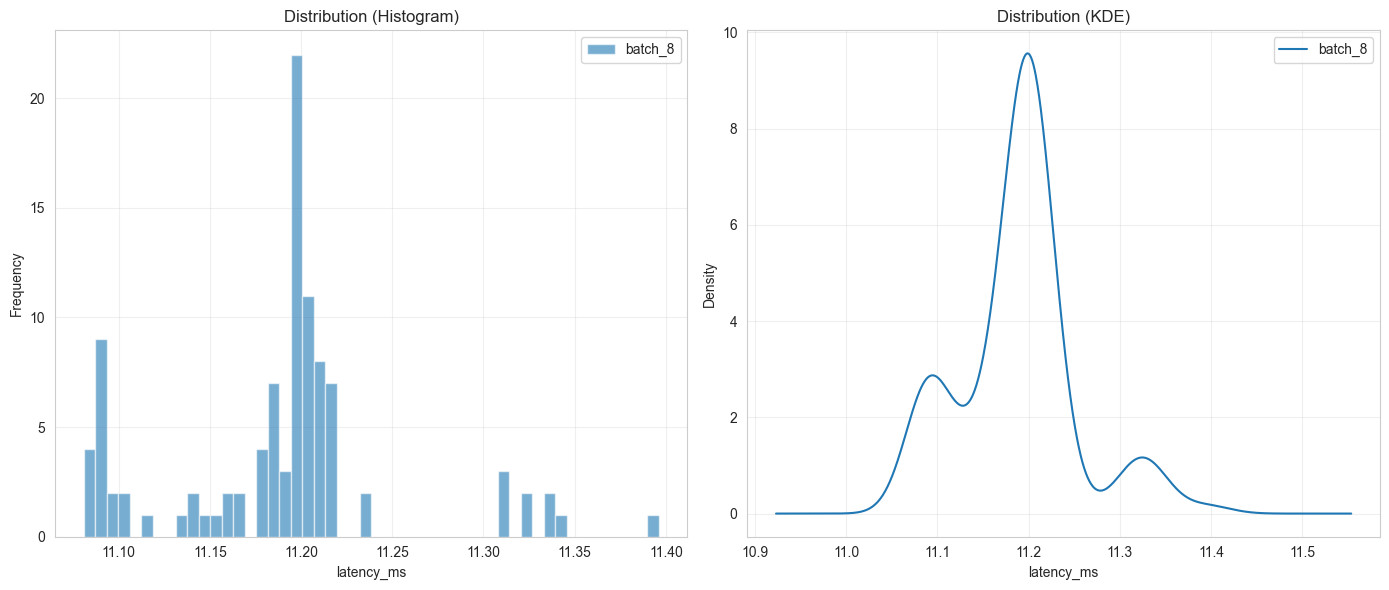

In [7]:
# Plot distributions (histogram and KDE)
analyzer.plot_distributions(plot_type='both', bins=50)

## Example 4: Compare Metrics Across Datasets

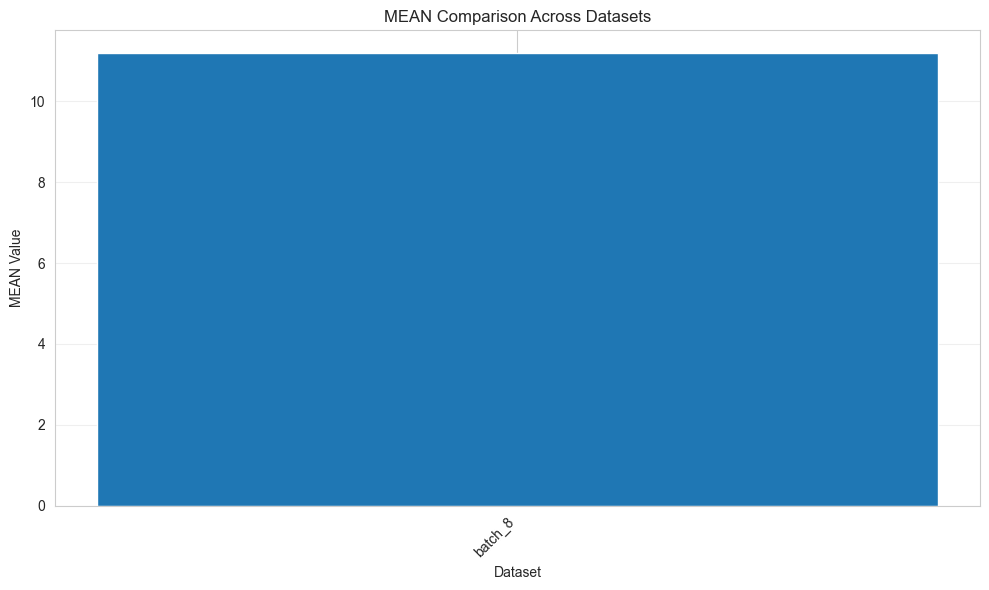

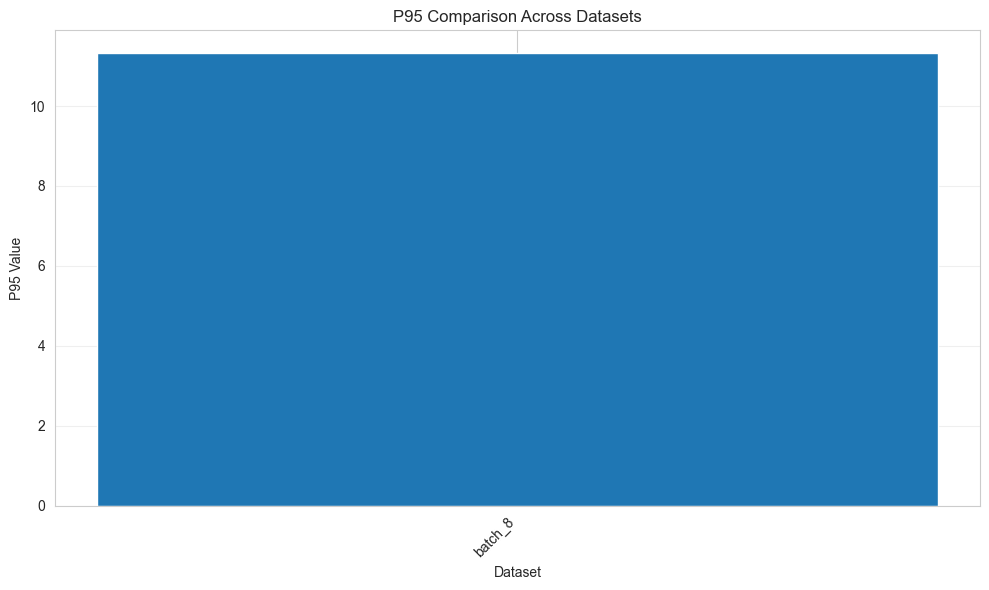

In [8]:
# Compare mean latencies
analyzer.plot_comparison(metric='mean')

# Compare p95 latencies
analyzer.plot_comparison(metric='p95')

## Example 5: Box Plot Comparison

/var/folders/pm/gwsfskks48j0z9y1sqy1xs640000gn/T/ipykernel_1869/3642657592.py:241: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=plot_labels)


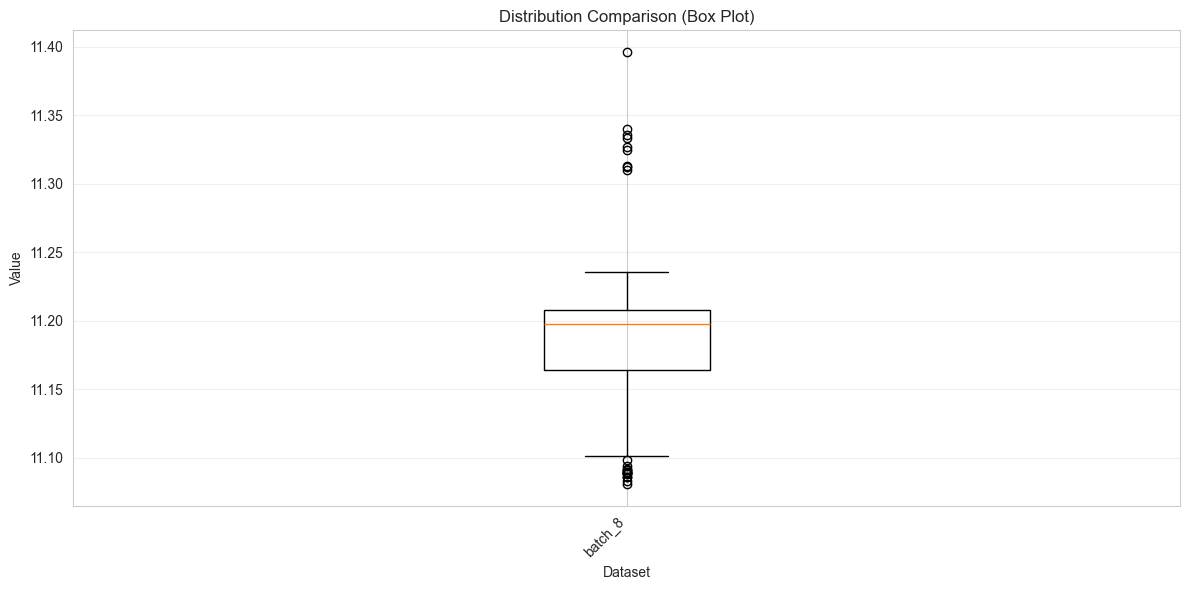

In [9]:
# Box plot for distribution comparison
analyzer.plot_boxplot()

## Example 6: Analyze Multi-GPU Experiments

Load and compare results from multi-GPU experiments.

Loaded 100 samples from distilgpt2_1_distilgpt2_b8_L128_latencies_ms.csv
Loaded 100 samples from distilgpt2_2_distilgpt2_b8_L128_latencies_ms.csv
Loaded 100 samples from distilgpt2_3_distilgpt2_b8_L128_latencies_ms.csv
        dataset  count       mean        p95        p99
0  distilgpt2_1    100  35.121459  35.622604  35.758254
1  distilgpt2_2    100  36.578120  37.020162  37.099273
2  distilgpt2_3    100  34.468065  34.790655  34.894348


/var/folders/pm/gwsfskks48j0z9y1sqy1xs640000gn/T/ipykernel_1869/3642657592.py:241: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=plot_labels)


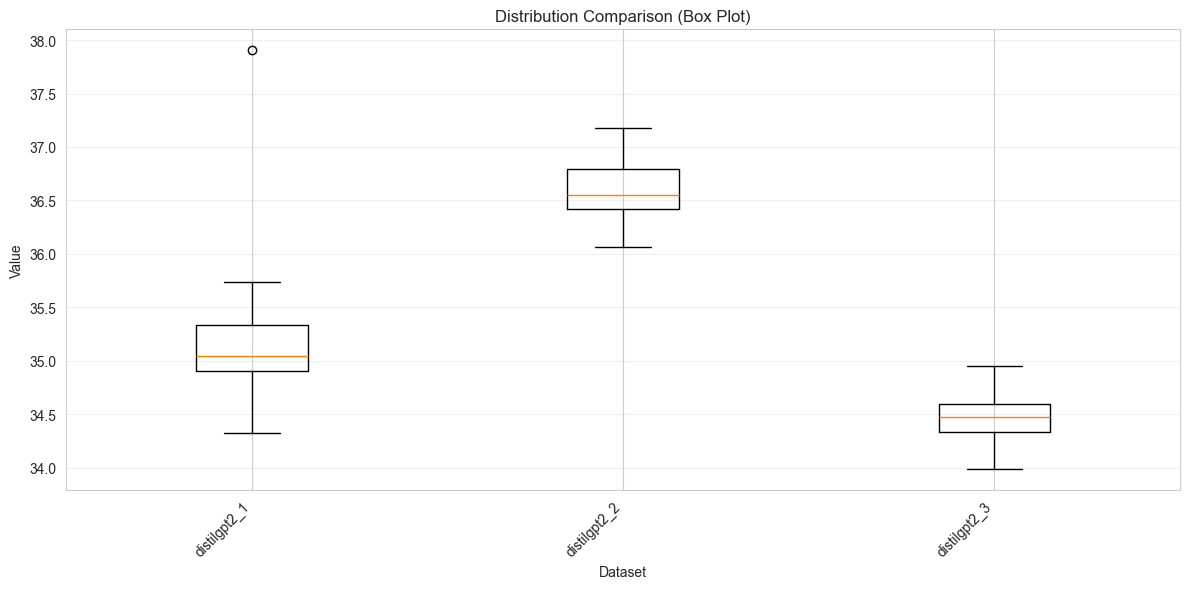

In [10]:
# Create fresh analyzer for multi-GPU experiments
multi_gpu_analyzer = DataAnalyzer()

# Load all 3-GPU experiments
multi_gpu_analyzer.load_pattern(
    '../data/3_distilgpt2_mps/**/*latencies_ms.csv',
    metric_name='latency_ms',
    label_extractor=extract_experiment_name
)

# Compute statistics
multi_stats = multi_gpu_analyzer.compute_statistics()
print(multi_stats[['dataset', 'count', 'mean', 'p95', 'p99']].to_string())

# Visualize
multi_gpu_analyzer.plot_boxplot()

## Example 7: Export Summary Statistics

In [11]:
# Export statistics to CSV
analyzer.export_summary('../results/summary_statistics.csv', percentiles=[50, 75, 90, 95, 99])

# You can also access the stats DataFrame directly
stats_df = analyzer.compute_statistics()
# ... and do further analysis or custom exports

OSError: Cannot save file into a non-existent directory: '../results'

## Example 8: Custom Analysis - Your Own Files

Template for analyzing your specific files.

In [ ]:
# ========================================
# YOUR CUSTOM ANALYSIS - EDIT THIS CELL
# ========================================

# Create analyzer
my_analyzer = DataAnalyzer()

# Option A: Load specific files
my_files = [
    # Add your file paths here
    # '../path/to/your/file1.csv',
    # '../path/to/your/file2.csv',
]

# Option B: Load using pattern
my_pattern = '../experiments/logs/*.csv'  # Change this to your pattern

# Define custom label extractor if needed
def my_label_extractor(filename):
    """
    Customize this function to extract meaningful labels from your filenames.
    Example: 'experiment_b8_L128.csv' -> 'batch_8'
    """
    # Your custom logic here
    return filename  # Default: use full filename

# Load data
# my_analyzer.load_files(my_files, metric_name='your_metric', label_extractor=my_label_extractor)
# OR
# my_analyzer.load_pattern(my_pattern, metric_name='your_metric', label_extractor=my_label_extractor)

# Analyze
# stats = my_analyzer.compute_statistics()
# print(stats)

# Visualize
# my_analyzer.plot_distributions()
# my_analyzer.plot_comparison(metric='mean')
# my_analyzer.plot_boxplot()

print("Edit this cell with your specific files and analysis needs!")

## Advanced: Adding New Metrics or Custom Analysis

You can easily extend the `DataAnalyzer` class or add custom analysis functions.

In [ ]:
# Example: Custom analysis function
def compute_throughput(analyzer, dataset_label, batch_size):
    """
    Compute throughput from latency measurements.
    
    Args:
        analyzer: DataAnalyzer instance
        dataset_label: Label of the dataset
        batch_size: Batch size used in experiment
    
    Returns:
        Throughput statistics
    """
    df = analyzer.get_data(dataset_label)
    metric_name = analyzer.metadata[dataset_label]['metric_name']
    
    # Latency in ms, convert to seconds
    latency_seconds = df[metric_name] / 1000.0
    
    # Throughput = batch_size / latency
    throughput = batch_size / latency_seconds
    
    return {
        'mean_throughput': throughput.mean(),
        'p50_throughput': throughput.quantile(0.5),
        'p95_throughput': throughput.quantile(0.95),
        'max_throughput': throughput.max()
    }

# Example: Add a method to the analyzer for your specific metric
def add_custom_metric(analyzer, metric_function):
    """
    Apply a custom transformation/metric to all loaded datasets.
    
    Args:
        analyzer: DataAnalyzer instance
        metric_function: Function that takes a DataFrame and returns transformed data
    """
    results = {}
    for label, df in analyzer.data.items():
        results[label] = metric_function(df)
    return results

# Example usage:
# throughput_stats = compute_throughput(analyzer, 'batch_8', batch_size=8)
# print(f"Throughput stats: {throughput_stats}")

print("Custom analysis functions defined!")

# Runtime Data Analysis

This notebook provides a flexible, generic data analysis framework for processing runtime metrics and performance data.

## Features
- Load data from CSV or JSON files individually or in bulk
- Flexible label extraction for organizing datasets
- Comprehensive statistical analysis (mean, std, percentiles, etc.)
- Multiple visualization options (histograms, KDE, box plots, bar charts)
- Easy to extend for new metrics or data types
- Export summaries to CSV